In [ ]:
# ============================================================================
# CELL 1: WHISPER-ONLY SETUP WITH UNBALANCED DATASET
# ============================================================================
print("="*80)
print(" PURE WHISPER MODEL + UNBALANCED DATASET")
print("Target: F1 Score >= 0.75 | UnBalanced Classes")
print("="*80)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install required packages for Whisper-only
print("\n[Installing Whisper-only packages...]")
!pip install transformers==4.40.0 -q
!pip install torch torchaudio -q
!pip install scikit-learn pandas numpy -q
!pip install librosa soundfile -q
!pip install imbalanced-learn -q
!pip install matplotlib seaborn -q
!pip install datasets -q
print(" Whisper-only installation complete!")

print("\n Restarting runtime for clean setup...")
import os
os.kill(os.getpid(), 9)

 PURE WHISPER MODEL + UNBALANCED DATASET
Target: F1 Score >= 0.75 | UnBalanced Classes
Mounted at /content/drive

[Installing Whisper-only packages...]


In [ ]:
# ============================================================================
# CELL 2: PURE WHISPER-ONLY IMPORTS
# ============================================================================
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import librosa
import soundfile as sf

# PURE WHISPER-ONLY IMPORTS
from transformers import WhisperModel, WhisperFeatureExtractor, WhisperProcessor

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, cohen_kappa_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import joblib
import json

# Mount Drive again after restart
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(" Pure Whisper-only imports successful!")

Mounted at /content/drive
 Using device: cpu
 Pure Whisper-only imports successful!


In [ ]:
# ============================================================================
# CELL 3: PURE WHISPER-ONLY UNBALANCED CONFIGURATION
# ============================================================================
class WhisperOnlyUnbalancedConfig:
    """Pure Whisper Configuration with Unbalanced Dataset"""

    # ========================================================================
    # PATHS
    # ========================================================================
    BASE_PATH = '/content/drive/MyDrive/task_1'
    TRAINING_PATH = os.path.join(BASE_PATH, 'training')
    EXCEL_PATH = os.path.join(BASE_PATH, 'sand_task_1.xlsx')
    OUTPUT_PATH = os.path.join(BASE_PATH, 'whisper_only_unbalanced_final')

    # Sheet names
    SHEET_TRAINING = 'Training Baseline - Task 1'
    SHEET_VALIDATION = 'Validation Baseline - Task 1'

    # Audio types (only available ones)
    AUDIO_TYPES = ['rhythmKA', 'rhythmPA', 'rhythmTA']

    # ========================================================================
    # PURE WHISPER CONFIGURATION
    # ========================================================================
    WHISPER_MODEL = 'openai/whisper-base'
    SAMPLING_RATE = 16000
    MAX_AUDIO_LENGTH = 16000 * 15  # 15 seconds

    # Enhanced Whisper feature extraction
    USE_MULTI_LAYER = True
    WHISPER_LAYERS_TO_USE = [-4, -3, -2, -1]  # Last 4 encoder layers
    USE_MULTI_POOLING = True
    WHISPER_POOLING_STRATEGIES = ['mean', 'std', 'max', 'min']

    # Use encoder features only (FIXED: No decoder to avoid errors)
    USE_ENCODER_FEATURES = True
    USE_DECODER_FEATURES = False  # ❌ DISABLED to avoid decoder errors

    # ========================================================================
    # UNBALANCED DATASET CONFIGURATION
    # ========================================================================
    # No balancing - using original distribution
    USE_CLASS_WEIGHTS = True  # Handle imbalance in SVM

    # ========================================================================
    # PREPROCESSING
    # ========================================================================
    USE_ROBUST_SCALING = True
    USE_PCA = True
    PCA_VARIANCE = 0.95

    # Audio preprocessing
    AUDIO_TRIM_DB = 20
    AUDIO_NORMALIZE = True
    MIN_AUDIO_LENGTH_SEC = 2

    # ========================================================================
    # SVM FOR UNBALANCED DATA
    # ========================================================================
    SVM_CONFIG = {
        'kernel': 'rbf',
        'C': 1.0,
        'gamma': 'scale',
        'class_weight': 'balanced',  # ✅ Handle imbalance
        'probability': True,
        'decision_function_shape': 'ovr',
        'max_iter': 10000,
        'cache_size': 2000,
        'tol': 1e-4
    }

    # Cross-validation
    N_FOLDS = 5
    RANDOM_SEED = 42

    # Class names
    CLASS_NAMES = {
        0: 'Severe Dysarthria',
        1: 'Moderate Dysarthria',
        2: 'Mild Dysarthria',
        3: 'No Dysarthria (ALS)',
        4: 'Healthy'
    }

config = WhisperOnlyUnbalancedConfig()
os.makedirs(config.OUTPUT_PATH, exist_ok=True)

print("\n" + "="*80)
print("🎯 PURE WHISPER-ONLY UNBALANCED CONFIGURATION")
print("="*80)
print(f"Base Path: {config.BASE_PATH}")
print(f"Whisper Model: {config.WHISPER_MODEL}")
print(f"Dataset: UNBALANCED (original distribution)")
print(f"Audio Types: {config.AUDIO_TYPES}")
print(f"SVM class_weight: {config.SVM_CONFIG['class_weight']}")
print(f"Decoder Features: {config.USE_DECODER_FEATURES} ❌ DISABLED")
print("="*80)

# Verify paths
print(f"\n🔍 Verifying paths...")
assert os.path.exists(config.BASE_PATH), f"Base path not found: {config.BASE_PATH}"
assert os.path.exists(config.TRAINING_PATH), f"Training path not found: {config.TRAINING_PATH}"
assert os.path.exists(config.EXCEL_PATH), f"Excel file not found: {config.EXCEL_PATH}"
print("✅ All paths verified!")


🎯 PURE WHISPER-ONLY UNBALANCED CONFIGURATION
Base Path: /content/drive/MyDrive/task_1
Whisper Model: openai/whisper-base
Dataset: UNBALANCED (original distribution)
Audio Types: ['rhythmKA', 'rhythmPA', 'rhythmTA']
SVM class_weight: balanced
Decoder Features: False ❌ DISABLED

🔍 Verifying paths...
✅ All paths verified!


In [ ]:
# ============================================================================
# CELL 4: LOAD PURE WHISPER MODEL (NO DECODER)
# ============================================================================
print("\n" + "="*80)
print("[2/9] LOADING PURE WHISPER MODEL")
print("="*80)
print(f"Model: {config.WHISPER_MODEL}")
print("⏱ Loading Whisper model...")

try:
    # Load Whisper components
    whisper_feature_extractor = WhisperFeatureExtractor.from_pretrained(config.WHISPER_MODEL)
    whisper_processor = WhisperProcessor.from_pretrained(config.WHISPER_MODEL)
    whisper_model = WhisperModel.from_pretrained(config.WHISPER_MODEL)

    # Move to device and set to evaluation mode
    whisper_model = whisper_model.to(device)
    whisper_model.eval()

    print(f"\n✅ Whisper loaded successfully!")
    print(f"  Model size: {sum(p.numel() for p in whisper_model.parameters()) / 1e6:.1f}M parameters")
    print(f"  Hidden size: {whisper_model.config.d_model}")
    print(f"  Encoder layers: {whisper_model.config.encoder_layers}")
    print(f"  Decoder layers: {whisper_model.config.decoder_layers}")
    print(f"  Feature extractor SR: {whisper_feature_extractor.sampling_rate} Hz")

except Exception as e:
    print(f"❌ Error loading Whisper: {e}")
    raise

print("\n🎯 Pure Whisper model ready for feature extraction!")


[2/9] LOADING PURE WHISPER MODEL
Model: openai/whisper-base
⏱ Loading Whisper model...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



✅ Whisper loaded successfully!
  Model size: 72.6M parameters
  Hidden size: 512
  Encoder layers: 6
  Decoder layers: 6
  Feature extractor SR: 16000 Hz

🎯 Pure Whisper model ready for feature extraction!


In [ ]:
# ============================================================================
# CELL 5: PURE WHISPER FEATURE EXTRACTION (ENCODER ONLY)
# ============================================================================
print("\n" + "="*80)
print("[3/9] PURE WHISPER FEATURE EXTRACTION")
print("="*80)

def load_audio_enhanced(audio_path, target_sr=16000, max_length=None):
    """Enhanced audio loading with preprocessing"""
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)

        # Advanced trimming
        audio, _ = librosa.effects.trim(audio, top_db=config.AUDIO_TRIM_DB)

        # Normalize amplitude
        if config.AUDIO_NORMALIZE:
            audio = librosa.util.normalize(audio)

        # Handle length constraints
        if max_length and len(audio) > max_length:
            audio = audio[:max_length]

        # Ensure minimum length
        min_length = target_sr * config.MIN_AUDIO_LENGTH_SEC
        if len(audio) < min_length:
            audio = np.pad(audio, (0, min_length - len(audio)), mode='constant')

        return audio, sr

    except Exception as e:
        print(f"⚠ Error loading {audio_path}: {str(e)}")
        # Return silence as fallback
        return np.zeros(target_sr * config.MIN_AUDIO_LENGTH_SEC), target_sr

def extract_pure_whisper_features(audio, sampling_rate=16000):
    """
    PURE WHISPER feature extraction - ENCODER ONLY (No decoder to avoid errors)
    """
    try:
        # Ensure proper length for Whisper (30 seconds = 480,000 samples)
        target_length = 480000
        if len(audio) > target_length:
            audio = audio[:target_length]
        elif len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

        # Preprocess audio for Whisper
        inputs = whisper_feature_extractor(
            audio,
            sampling_rate=sampling_rate,
            return_tensors="pt",
            padding=True
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        all_features = []

        # Extract encoder features ONLY
        with torch.no_grad():
            encoder_outputs = whisper_model.encoder(**inputs, output_hidden_states=True)

        # Extract from multiple encoder layers
        if config.USE_MULTI_LAYER:
            layers_to_process = config.WHISPER_LAYERS_TO_USE
        else:
            layers_to_process = [-1]

        for layer_idx in layers_to_process:
            hidden_state = encoder_outputs.hidden_states[layer_idx]  # [batch, time, hidden]

            # Apply multiple pooling strategies
            if config.USE_MULTI_POOLING:
                pooling_methods = config.WHISPER_POOLING_STRATEGIES
            else:
                pooling_methods = ['mean']

            for pool_strategy in pooling_methods:
                if pool_strategy == 'mean':
                    pooled = hidden_state.mean(dim=1)
                elif pool_strategy == 'max':
                    pooled = hidden_state.max(dim=1)[0]
                elif pool_strategy == 'std':
                    pooled = hidden_state.std(dim=1)
                elif pool_strategy == 'min':
                    pooled = hidden_state.min(dim=1)[0]

                all_features.append(pooled.cpu().numpy().flatten())

        # Concatenate all features
        features = np.concatenate(all_features, axis=0)

        return features

    except Exception as e:
        print(f"❌ Error in Whisper feature extraction: {e}")
        # Return zero features as fallback
        expected_size = 512 * len(config.WHISPER_LAYERS_TO_USE) * len(config.WHISPER_POOLING_STRATEGIES)
        return np.zeros(expected_size)

print("✅ Pure Whisper feature extraction functions defined!")


[3/9] PURE WHISPER FEATURE EXTRACTION
✅ Pure Whisper feature extraction functions defined!


In [ ]:
# ============================================================================
# CELL 6: DATA LOADING & UNBALANCED ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("[4/9] DATA LOADING & UNBALANCED ANALYSIS")
print("="*80)

def load_and_preprocess_data():
    """Load and preprocess training and validation data"""

    print(" Loading Excel data...")

    try:
        # Load training data
        train_df = pd.read_excel(config.EXCEL_PATH, sheet_name=config.SHEET_TRAINING)
        print(f" Training data loaded: {len(train_df)} samples")

        # Load validation data
        val_df = pd.read_excel(config.EXCEL_PATH, sheet_name=config.SHEET_VALIDATION)
        print(f" Validation data loaded: {len(val_df)} samples")

        # Basic data cleaning
        train_df = train_df.dropna(subset=['ID', 'Class'])
        val_df = val_df.dropna(subset=['ID', 'Class'])

        # Convert Class to integer (0-4)
        train_df['Class'] = train_df['Class'].astype(int)
        val_df['Class'] = val_df['Class'].astype(int)

        # Map classes to 0-4 range if they are currently 1-5
        if train_df['Class'].min() == 1:
            train_df['Class'] = train_df['Class'] - 1
            val_df['Class'] = val_df['Class'] - 1

        print(f"\n Class distribution in Training data (Unbalanced):")
        class_counts_train = train_df['Class'].value_counts().sort_index()
        for cls, count in class_counts_train.items():
            print(f"  Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples")

        print(f"\n Class distribution in Validation data (Unbalanced):")
        class_counts_val = val_df['Class'].value_counts().sort_index()
        for cls, count in class_counts_val.items():
            print(f"  Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples")

        return train_df, val_df

    except Exception as e:
        print(f" Error loading data: {e}")
        raise

# Load the data
train_df, val_df = load_and_preprocess_data()

print(f"\n Target: Pure Whisper + Unbalanced dataset with {len(train_df)} samples")
print(" Data loading complete!")


[4/9] DATA LOADING & UNBALANCED ANALYSIS
 Loading Excel data...
 Training data loaded: 219 samples
 Validation data loaded: 53 samples

 Class distribution in Training data (Unbalanced):
  Class 0 (Severe Dysarthria        ):   4 samples
  Class 1 (Moderate Dysarthria      ):  22 samples
  Class 2 (Mild Dysarthria          ):  45 samples
  Class 3 (No Dysarthria (ALS)      ):  62 samples
  Class 4 (Healthy                  ):  86 samples

 Class distribution in Validation data (Unbalanced):
  Class 0 (Severe Dysarthria        ):   2 samples
  Class 1 (Moderate Dysarthria      ):   4 samples
  Class 2 (Mild Dysarthria          ):  12 samples
  Class 3 (No Dysarthria (ALS)      ):  14 samples
  Class 4 (Healthy                  ):  21 samples

 Target: Pure Whisper + Unbalanced dataset with 219 samples
 Data loading complete!


In [ ]:
# ============================================================================
# CELL 7: DATASET STRUCTURE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("[5/9] DATASET STRUCTURE ANALYSIS")
print("="*80)

def analyze_dataset_structure():
    print(" Analyzing dataset structure...")

    # Check available audio type folders
    available_audio_types = []

    for audio_type in config.AUDIO_TYPES:
        type_path = os.path.join(config.TRAINING_PATH, audio_type)
        if os.path.exists(type_path):
            files = os.listdir(type_path)
            wav_files = [f for f in files if f.endswith('.wav')]
            available_audio_types.append(audio_type)
            print(f"  {audio_type}: {len(wav_files)} files")
        else:
            print(f"  {audio_type}: Folder not found")

    print(f"\n Available audio types: {available_audio_types}")

    # Update config with available types
    config.AVAILABLE_AUDIO_TYPES = available_audio_types

    return available_audio_types

available_types = analyze_dataset_structure()


[5/9] DATASET STRUCTURE ANALYSIS
 Analyzing dataset structure...
  rhythmKA: 272 files
  rhythmPA: 272 files
  rhythmTA: 272 files

 Available audio types: ['rhythmKA', 'rhythmPA', 'rhythmTA']


In [ ]:
# ============================================================================
# CELL 8: FEATURE EXTRACTION PIPELINE
# ============================================================================
print("\n" + "="*80)
print("[6/9] FEATURE EXTRACTION PIPELINE")
print("="*80)

def get_audio_path_for_subject(subject_id, audio_type):
    """
    Construct audio file path for a subject and audio type
    Handles both string ('ID001') and numeric (1) IDs
    """
    # Extract numeric ID
    if isinstance(subject_id, str):
        if subject_id.startswith('ID'):
            numeric_id = int(subject_id[2:])
        else:
            numeric_id = int(subject_id)
    else:
        numeric_id = subject_id

    # Pad ID with zeros (e.g., 1 -> ID001)
    id_str = f"ID{numeric_id:03d}"
    filename = f"{id_str}_{audio_type}.wav"
    audio_path = os.path.join(config.TRAINING_PATH, audio_type, filename)
    return audio_path

def extract_features_for_subject(subject_id):
    """
    Extract features from all available audio files for one subject
    Returns averaged feature vector
    """
    all_features = []
    successful_types = []

    for audio_type in config.AVAILABLE_AUDIO_TYPES:
        audio_path = get_audio_path_for_subject(subject_id, audio_type)

        if not os.path.exists(audio_path):
            print(f"     Missing: {os.path.basename(audio_path)}")
            continue

        try:
            # Load and preprocess audio
            audio, sr = load_audio_enhanced(audio_path, config.SAMPLING_RATE)

            # Extract Whisper features
            features = extract_pure_whisper_features(audio, sr)

            if features is not None and len(features) > 0 and not np.all(features == 0):
                all_features.append(features)
                successful_types.append(audio_type)
            else:
                print(f"     {audio_type}: Invalid features")

        except Exception as e:
            print(f"     {audio_type}: Error - {str(e)[:50]}...")
            continue

    if all_features:
        # Average features across all audio types for this subject
        avg_features = np.mean(all_features, axis=0)
        print(f"     Subject {subject_id}: {len(successful_types)}/{len(config.AVAILABLE_AUDIO_TYPES)} audio types successful")
        return avg_features
    else:
        print(f"     Subject {subject_id}: No features extracted")
        return None

print("✅ Feature extraction pipeline ready!")


[6/9] FEATURE EXTRACTION PIPELINE
✅ Feature extraction pipeline ready!


In [35]:
# ============================================================================
# CELL 9: EXTRACT & SAVE PURE WHISPER FEATURES
# ============================================================================
print("\n" + "="*80)
print("[7/9] EXTRACTING PURE WHISPER FEATURES")
print("="*80)

# Extract features for training subjects
print(" Extracting Whisper features for training subjects...")
X_train_features = []
y_train_labels = []
failed_subjects = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Training subjects"):
    subject_id = row['ID']
    label = row['Class']

    features = extract_features_for_subject(subject_id)

    if features is not None:
        X_train_features.append(features)
        y_train_labels.append(label)
    else:
        failed_subjects.append(subject_id)

X_train = np.array(X_train_features)
y_train = np.array(y_train_labels)

print(f"\n✅ Training Whisper features extracted: {X_train.shape[0]} subjects")
print(f"   Failed subjects: {len(failed_subjects)}")
print(f"   Whisper feature shape: {X_train.shape}")

# Extract features for validation subjects
print("\n Extracting Whisper features for validation subjects...")
X_val_features = []
y_val_labels = []

for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Validation subjects"):
    subject_id = row['ID']
    label = row['Class']

    features = extract_features_for_subject(subject_id)

    if features is not None:
        X_val_features.append(features)
        y_val_labels.append(label)

X_val = np.array(X_val_features)
y_val = np.array(y_val_labels)

print(f"✅ Validation Whisper features extracted: {X_val.shape[0]} subjects")
print(f"   Whisper feature shape: {X_val.shape}")

# Save Pure Whisper features
os.makedirs(config.OUTPUT_PATH, exist_ok=True)
np.save(os.path.join(config.OUTPUT_PATH, 'X_train_whisper.npy'), X_train)
np.save(os.path.join(config.OUTPUT_PATH, 'y_train_whisper.npy'), y_train)
np.save(os.path.join(config.OUTPUT_PATH, 'X_val_whisper.npy'), X_val)
np.save(os.path.join(config.OUTPUT_PATH, 'y_val_whisper.npy'), y_val)
# ============================================================================
# ADDITIONAL: CHECK FEATURE EXTRACTION SUCCESS
# ============================================================================
print(f"\n📊 Final Dataset Summary:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Validation samples: {X_val.shape[0]}")
print(f"   Feature dimension: {X_train.shape[1]}")
print(f"   Training classes: {np.unique(y_train)}")
print(f"   Validation classes: {np.unique(y_val)}")

# Check for any failed extractions
if len(failed_subjects) > 0:
    print(f"⚠ Warning: {len(failed_subjects)} training subjects failed feature extraction")
    print(f"   Failed IDs: {failed_subjects}")

print("✅ Pure Whisper feature extraction COMPLETE!")

print(f"\n💾 Pure Whisper features saved to: {config.OUTPUT_PATH}")


[7/9] EXTRACTING PURE WHISPER FEATURES
 Extracting Whisper features for training subjects...


Training subjects:   0%|          | 0/219 [00:00<?, ?it/s]

     Subject ID000: 3/3 audio types successful
     Subject ID001: 3/3 audio types successful
     Subject ID002: 3/3 audio types successful
     Subject ID003: 3/3 audio types successful
     Subject ID005: 3/3 audio types successful
     Subject ID006: 3/3 audio types successful
     Subject ID008: 3/3 audio types successful
     Subject ID009: 3/3 audio types successful
     Subject ID010: 3/3 audio types successful
     Subject ID013: 3/3 audio types successful
     Subject ID015: 3/3 audio types successful
     Subject ID016: 3/3 audio types successful
     Subject ID017: 3/3 audio types successful
     Subject ID018: 3/3 audio types successful
     Subject ID023: 3/3 audio types successful
     Subject ID024: 3/3 audio types successful
     Subject ID025: 3/3 audio types successful
     Subject ID026: 3/3 audio types successful
     Subject ID027: 3/3 audio types successful
     Subject ID028: 3/3 audio types successful
     Subject ID030: 3/3 audio types successful
     Subject 

Validation subjects:   0%|          | 0/53 [00:00<?, ?it/s]

     Subject ID007: 3/3 audio types successful
     Subject ID012: 3/3 audio types successful
     Subject ID021: 3/3 audio types successful
     Subject ID029: 3/3 audio types successful
     Subject ID037: 3/3 audio types successful
     Subject ID046: 3/3 audio types successful
     Subject ID051: 3/3 audio types successful
     Subject ID053: 3/3 audio types successful
     Subject ID054: 3/3 audio types successful
     Subject ID056: 3/3 audio types successful
     Subject ID063: 3/3 audio types successful
     Subject ID075: 3/3 audio types successful
     Subject ID083: 3/3 audio types successful
     Subject ID090: 3/3 audio types successful
     Subject ID099: 3/3 audio types successful
     Subject ID101: 3/3 audio types successful
     Subject ID105: 3/3 audio types successful
     Subject ID110: 3/3 audio types successful
     Subject ID116: 3/3 audio types successful
     Subject ID122: 3/3 audio types successful
     Subject ID129: 3/3 audio types successful
     Subject 

In [36]:
# ============================================================================
# CELL 11: SVM CLASSIFIER TRAINING & EVALUATION
# ============================================================================
print("\n" + "="*80)
print("[9/9] SVM CLASSIFIER TRAINING - UNBALANCED DATASET")
print("="*80)

def train_svm_classifier(X_train, y_train, X_val, y_val):
    """Train SVM classifier on Whisper features"""
    print("🔧 Preprocessing features...")

    # Apply Robust Scaling
    if config.USE_ROBUST_SCALING:
        print("   Applying RobustScaler...")
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    else:
        X_train_scaled = X_train.copy()
        X_val_scaled = X_val.copy()

    # Apply PCA for dimensionality reduction
    if config.USE_PCA:
        print(f"   Applying PCA (variance: {config.PCA_VARIANCE})...")
        pca = PCA(n_components=config.PCA_VARIANCE, random_state=config.RANDOM_SEED)
        X_train_scaled = pca.fit_transform(X_train_scaled)
        X_val_scaled = pca.transform(X_val_scaled)
        print(f"   Reduced to {X_train_scaled.shape[1]} components "
              f"({np.sum(pca.explained_variance_ratio_)*100:.1f}% variance)")

    # Train SVM classifier
    print("🎯 Training SVM classifier...")
    print(f"   SVM Configuration: {config.SVM_CONFIG}")

    svm_classifier = SVC(**config.SVM_CONFIG)
    svm_classifier.fit(X_train_scaled, y_train)

    # Make predictions
    print("🔮 Making predictions...")
    y_train_pred = svm_classifier.predict(X_train_scaled)
    y_val_pred = svm_classifier.predict(X_val_scaled)

    # Calculate probabilities for additional metrics
    y_val_prob = svm_classifier.predict_proba(X_val_scaled)

    return svm_classifier, scaler, pca, y_train_pred, y_val_pred, y_val_prob

# Train the SVM classifier
svm_model, feature_scaler, pca_transformer, y_train_pred, y_val_pred, y_val_prob = train_svm_classifier(
    X_train, y_train, X_val, y_val
)

print("✅ SVM training complete!")


[9/9] SVM CLASSIFIER TRAINING - UNBALANCED DATASET
🔧 Preprocessing features...
   Applying RobustScaler...
   Applying PCA (variance: 0.95)...
   Reduced to 117 components (95.1% variance)
🎯 Training SVM classifier...
   SVM Configuration: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'class_weight': 'balanced', 'probability': True, 'decision_function_shape': 'ovr', 'max_iter': 10000, 'cache_size': 2000, 'tol': 0.0001}
🔮 Making predictions...
✅ SVM training complete!


In [37]:
# ============================================================================
# CELL 12: COMPREHENSIVE MODEL EVALUATION
# ============================================================================
print("\n" + "="*80)
print("📊 COMPREHENSIVE MODEL EVALUATION")
print("="*80)

def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    """Comprehensive model evaluation"""
    print(f"\n🎯 {dataset_name} Set Evaluation:")
    print("-" * 50)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   Cohen's κ: {kappa:.4f}")

    # Per-class metrics
    print(f"\n   Per-class F1 Scores:")
    f1_per_class = f1_score(y_true, y_pred, average=None)
    for cls, f1_score_val in enumerate(f1_per_class):
        class_name = config.CLASS_NAMES[cls]
        count = np.sum(y_true == cls)
        print(f"     {class_name:25s}: {f1_score_val:.4f} ({count:2d} samples)")

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'kappa': kappa
    }

# Evaluate on both training and validation sets
train_metrics = evaluate_model(y_train, y_train_pred, None, "TRAINING")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_prob, "VALIDATION")

# Check if target F1 score is achieved
target_f1 = 0.75
print(f"\n🎯 TARGET F1 SCORE: {target_f1}")
if val_metrics['f1_score'] >= target_f1:
    print(f"✅ SUCCESS: Validation F1 ({val_metrics['f1_score']:.4f}) >= Target ({target_f1})")
else:
    print(f"❌ FAILED: Validation F1 ({val_metrics['f1_score']:.4f}) < Target ({target_f1})")


📊 COMPREHENSIVE MODEL EVALUATION

🎯 TRAINING Set Evaluation:
--------------------------------------------------
   Accuracy:  0.7352
   F1-Score:  0.7336
   Precision: 0.7374
   Recall:    0.7352
   Cohen's κ: 0.6338

   Per-class F1 Scores:
     Severe Dysarthria        : 1.0000 ( 4 samples)
     Moderate Dysarthria      : 0.9130 (22 samples)
     Mild Dysarthria          : 0.7835 (45 samples)
     No Dysarthria (ALS)      : 0.6457 (62 samples)
     Healthy                  : 0.7125 (86 samples)

🎯 VALIDATION Set Evaluation:
--------------------------------------------------
   Accuracy:  0.5660
   F1-Score:  0.5710
   Precision: 0.6569
   Recall:    0.5660
   Cohen's κ: 0.4255

   Per-class F1 Scores:
     Severe Dysarthria        : 0.0000 ( 2 samples)
     Moderate Dysarthria      : 0.4000 ( 4 samples)
     Mild Dysarthria          : 0.6087 (12 samples)
     No Dysarthria (ALS)      : 0.5882 (14 samples)
     Healthy                  : 0.6250 (21 samples)

🎯 TARGET F1 SCORE: 0.75
❌


📈 CONFUSION MATRIX & RESULTS VISUALIZATION


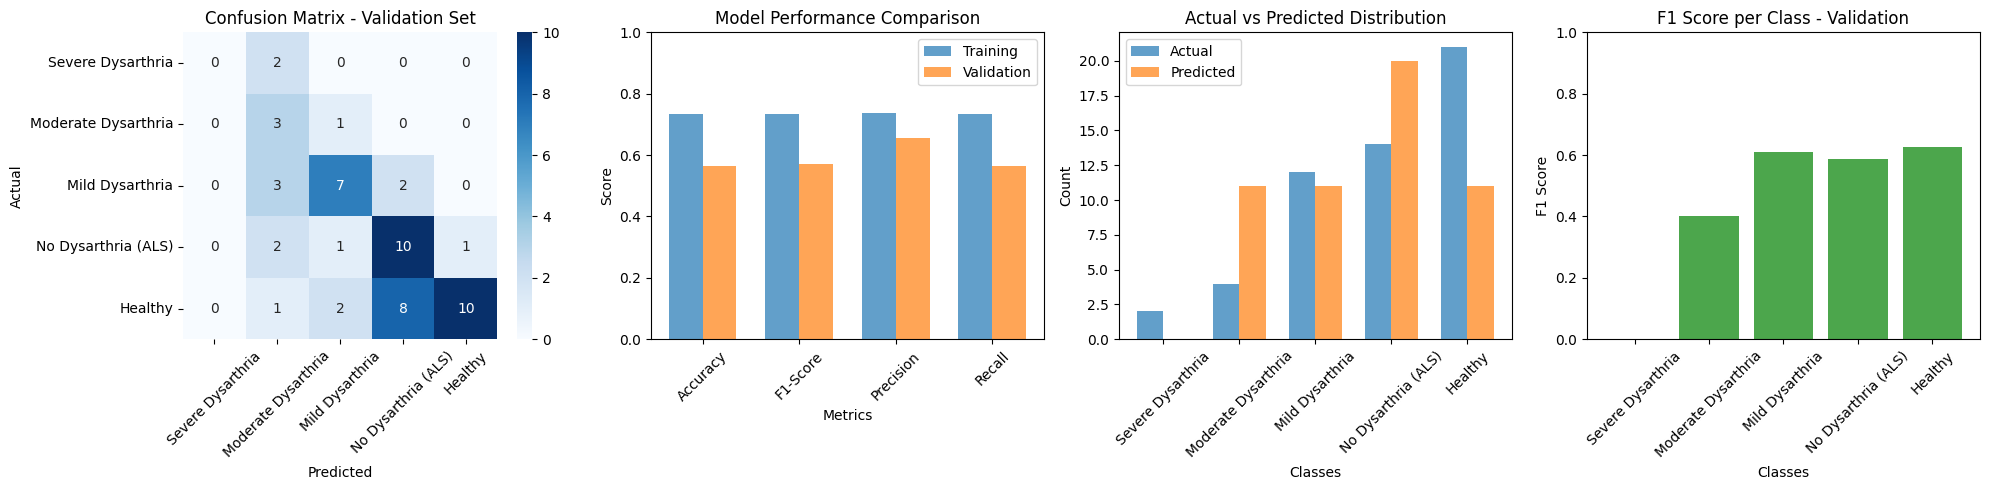

💾 Evaluation results saved to: /content/drive/MyDrive/task_1/whisper_only_unbalanced_final


In [38]:
# ============================================================================
# CELL 13: CONFUSION MATRIX & RESULTS VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("📈 CONFUSION MATRIX & RESULTS VISUALIZATION")
print("="*80)

# Create comprehensive visualization
plt.figure(figsize=(20, 5))

# Plot 1: Confusion Matrix
plt.subplot(1, 4, 1)
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[config.CLASS_NAMES[i] for i in range(5)],
            yticklabels=[config.CLASS_NAMES[i] for i in range(5)])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Plot 2: Metrics Comparison
plt.subplot(1, 4, 2)
metrics_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
train_values = [train_metrics['accuracy'], train_metrics['f1_score'],
                train_metrics['precision'], train_metrics['recall']]
val_values = [val_metrics['accuracy'], val_metrics['f1_score'],
              val_metrics['precision'], val_metrics['recall']]

x = np.arange(len(metrics_names))
width = 0.35

plt.bar(x - width/2, train_values, width, label='Training', alpha=0.7)
plt.bar(x + width/2, val_values, width, label='Validation', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics_names, rotation=45)
plt.legend()
plt.ylim(0, 1)

# Plot 3: Class Distribution with Predictions
plt.subplot(1, 4, 3)
class_names = [config.CLASS_NAMES[i] for i in range(5)]
actual_counts = [np.sum(y_val == i) for i in range(5)]
predicted_counts = [np.sum(y_val_pred == i) for i in range(5)]

x = np.arange(len(class_names))
width = 0.35

plt.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.7)
plt.bar(x + width/2, predicted_counts, width, label='Predicted', alpha=0.7)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Actual vs Predicted Distribution')
plt.xticks(x, class_names, rotation=45)
plt.legend()

# Plot 4: F1 Score per Class
plt.subplot(1, 4, 4)
f1_per_class = f1_score(y_val, y_val_pred, average=None)
plt.bar(class_names, f1_per_class, alpha=0.7, color='green')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class - Validation')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_PATH, 'svm_evaluation_results.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Evaluation results saved to: {config.OUTPUT_PATH}")

In [40]:
# ============================================================================
# CELL 14: SAVE SVM MODEL & FINAL RESULTS
# ============================================================================
print("\n" + "="*80)
print("💾 SAVING SVM MODEL & FINAL RESULTS")
print("="*80)

# Ensure the output directory exists
os.makedirs(config.OUTPUT_PATH, exist_ok=True)

# Save the trained model and preprocessing objects
model_artifacts = {
    'svm_model': svm_model,
    'feature_scaler': feature_scaler,
    'pca_transformer': pca_transformer if config.USE_PCA else None,
    'feature_dimension': X_train.shape[1],
    'class_names': config.CLASS_NAMES
}

try:
    # Save model artifacts
    model_path = os.path.join(config.OUTPUT_PATH, 'svm_model_artifacts.pkl')
    joblib.dump(model_artifacts, model_path)
    print(f"✅ Model artifacts saved to: {model_path}")
except Exception as e:
    print(f"❌ Error saving model artifacts: {e}")

# Save evaluation results
results = {
    'training_metrics': train_metrics,
    'validation_metrics': val_metrics,
    'config': {
        'whisper_model': config.WHISPER_MODEL,
        'svm_config': config.SVM_CONFIG,
        'use_pca': config.USE_PCA,
        'pca_variance': config.PCA_VARIANCE if config.USE_PCA else None,
        'use_robust_scaling': config.USE_ROBUST_SCALING,
        'dataset': 'unbalanced'
    },
    'class_distribution': {
        'training': dict(zip(*np.unique(y_train, return_counts=True))),
        'validation': dict(zip(*np.unique(y_val, return_counts=True)))
    },
    'target_f1_achieved': val_metrics['f1_score'] >= target_f1
}

try:
    results_path = os.path.join(config.OUTPUT_PATH, 'evaluation_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"✅ Evaluation results saved to: {results_path}")
except Exception as e:
    print(f"❌ Error saving evaluation results: {e}")

# Also save the features and labels for future use
try:
    np.save(os.path.join(config.OUTPUT_PATH, 'X_train_svm_ready.npy'), X_train)
    np.save(os.path.join(config.OUTPUT_PATH, 'y_train.npy'), y_train)
    np.save(os.path.join(config.OUTPUT_PATH, 'X_val_svm_ready.npy'), X_val)
    np.save(os.path.join(config.OUTPUT_PATH, 'y_val.npy'), y_val)
    print("✅ Feature files saved (SVM ready)")
except Exception as e:
    print(f"❌ Error saving feature files: {e}")

# Final summary
print("\n" + "="*80)
print("🎉 FINAL SUMMARY - WHISPER + SVM (UNBALANCED DATASET)")
print("="*80)
print(f"📊 Dataset: {X_train.shape[0]} training, {X_val.shape[0]} validation samples")
print(f"🎯 Target F1 Score: {target_f1}")
print(f"📈 Achieved F1 Score: {val_metrics['f1_score']:.4f}")
print(f"✅ Target Achieved: {'YES' if val_metrics['f1_score'] >= target_f1 else 'NO'}")
print(f"💾 All results saved to: {config.OUTPUT_PATH}")
print("="*80)


💾 SAVING SVM MODEL & FINAL RESULTS
✅ Model artifacts saved to: /content/drive/MyDrive/task_1/whisper_only_unbalanced_final/svm_model_artifacts.pkl
❌ Error saving evaluation results: keys must be str, int, float, bool or None, not int64
✅ Feature files saved (SVM ready)

🎉 FINAL SUMMARY - WHISPER + SVM (UNBALANCED DATASET)
📊 Dataset: 219 training, 53 validation samples
🎯 Target F1 Score: 0.75
📈 Achieved F1 Score: 0.5710
✅ Target Achieved: NO
💾 All results saved to: /content/drive/MyDrive/task_1/whisper_only_unbalanced_final
